# Basics of PyTorch - Datasets & DataLoaders
### Date: 02/20/2025
### by Malik N. Mohammed

## Objectives
- Understand Datasets and DataLoaders in PyTorch
- Loading and interating dataset
- Train and Test dataset
- Custom dataset loader from MNIST


PyTorch provides two main data primitives:
- `torch.utils.data.DataLoader`
  - `DataLoader` wraps an iterable around the `Dataset` for easy access of data
- `torch.utils.data.Dataset`
  - Allows to use pre-loaded datasets and our custom data.


In [14]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch

In [5]:
# Download the dataset and mark it as training dataset and transform to Tensor.
training_data = datasets.FashionMNIST(
  root='data',
  train=True,
  download=True,
  transform=ToTensor()
)

100%|████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 4.70MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 7.70MB/s]


In [7]:
# Download the dataset and mark it as test dataset and transform it to Tensor.
test_data = datasets.FashionMNIST(
  root='data',
  download=True,
  train=False,
  transform=ToTensor()
)

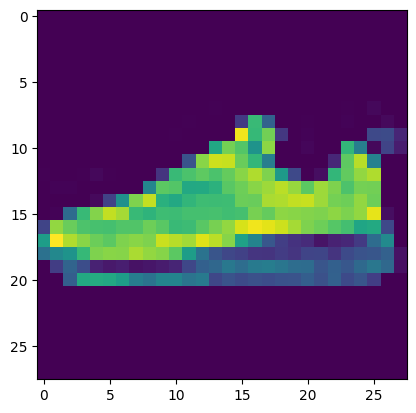

In [22]:
img, label = training_data[torch.randint(len(training_data), size=(1, )).item()]
plt.imshow(img.squeeze())
plt.show()

## Creating Custom Dataset - MNIST
PyTorch allows you to create custom dataset with the Dataset as the interface and requires you to implement three main functions: `__init__`, `__len__`, and `__getitem__`

In the next few cells we are going to implement custom dataset for the MNIST.

In [23]:
# Download MNIST dataset
datasets.MNIST(
  'data',
  download=True,
  train=True
)

100%|████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 1.32MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 9.67MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.45MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [71]:
!ls -alh data/MNIST/raw

total 64M
drwxrwxr-x 2 malik malik 4.0K Feb 20 07:48 .
drwxrwxr-x 3 malik malik 4.0K Feb 20 07:48 ..
-rw-rw-r-- 1 malik malik 7.5M Feb 20 07:48 t10k-images-idx3-ubyte
-rw-rw-r-- 1 malik malik 1.6M Feb 20 07:48 t10k-images-idx3-ubyte.gz
-rw-rw-r-- 1 malik malik 9.8K Feb 20 07:48 t10k-labels-idx1-ubyte
-rw-rw-r-- 1 malik malik 4.5K Feb 20 07:48 t10k-labels-idx1-ubyte.gz
-rw-rw-r-- 1 malik malik  45M Feb 20 07:48 train-images-idx3-ubyte
-rw-rw-r-- 1 malik malik 9.5M Feb 20 07:48 train-images-idx3-ubyte.gz
-rw-rw-r-- 1 malik malik  59K Feb 20 07:48 train-labels-idx1-ubyte
-rw-rw-r-- 1 malik malik  29K Feb 20 07:48 train-labels-idx1-ubyte.gz


In [72]:
# Import numpy and struct
import numpy as np
import struct

In [81]:
class CustomMnistDataset(Dataset):
    def __init__(self, image_path, label_path, transform=None, target_transform=None):

        self.image_path = image_path
        self.label_path = label_path
        self.images = self.load_images()
        self.labels = self.load_labels()
            
        self.transform = transform
        self.target_transform = target_transform

    def load_images(self):
        """
        Load images from the dataset into numpy array of shape: (num_images, rows, cols) => (60000, 28, 28)
        """
        
        with open(self.image_path, 'rb') as f:
            # Read the first 8 bytes of the file header and get file type and num image information.
            file_type, num_images = struct.unpack('>II', f.read(8))

            if file_type != 2051:
                raise ValueError(f'Invalid file type value {file_type} in image file.')

            # Read another 8 bytes and get number of rows and columsn.
            rows, cols = struct.unpack('>II', f.read(8))

            # Read the remaining dataset from buffer and load as numpy array.
            images = np.frombuffer(f.read(), dtype=np.uint8)

            # Reshape the loaded numpy array to (num_images, rows, cols)
            images = images.reshape(num_images, rows, cols)
            
            return images

    def load_labels(self):
        """
        Load labels from the dataset into numpy array of shape: (num_labels, ) => (60000, )
        """

        with open(self.label_path, 'rb') as f:
            # Read the first 8 bytes of the file header and get file type and number of labels.
            file_type, num_labels = struct.unpack('>II', f.read(8))

            if file_type != 2049:
                raise ValueError(f'Invalid file type value {file_type} in label file.')

            # Read the labels from buffer and load as numpy array of type uint8
            return np.frombuffer(f.read(), dtype=np.uint8)
            
    def __len__(self):
        """
        Return the number of samples in this dataset.
        """
        
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Return the sample at the specified index along with some transformations to images and labels.
        """
        
        image, label = self.images[idx], self.labels[idx]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [82]:
custom_data = CustomMnistDataset(
    image_path='data/MNIST/raw/train-images-idx3-ubyte', 
    label_path='data/MNIST/raw/train-labels-idx1-ubyte',
    transform=ToTensor(),
    target_transform=torch.tensor
)

In [83]:
custom_data.labels.shape

(60000,)

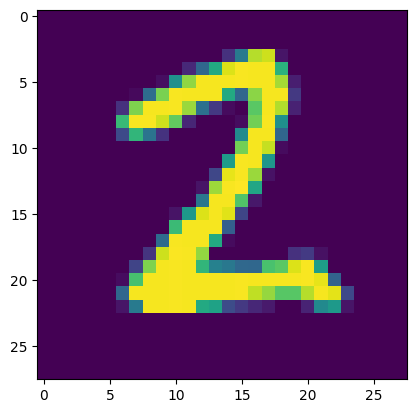

Label: 2


In [84]:
# Visualizing the random sample from the custom dataset.

img, label = custom_data[torch.randint(len(custom_data), size=(1, )).item()]
plt.imshow(img.squeeze())
plt.show()
print(f'Label: {label}')

## Iterating through the Dataset with the Dataloader
In this sections we will look at how to iterate over the dataset that we just created and iterate over it in batches.

In [103]:
from torch.utils.data import DataLoader

dataloader = DataLoader(custom_data, batch_size=32, shuffle=True)
dataloader

In [104]:
# Get DataLoader iterator.
dataloader_iterator = iter(dataloader)

In [105]:
dataloader_iterator

In [106]:
image, label = next(dataloader_iterator)

print(f'Image batch shape: {image.shape}')
print(f'Label batch shape: {label.shape}')

Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])


Label: 0


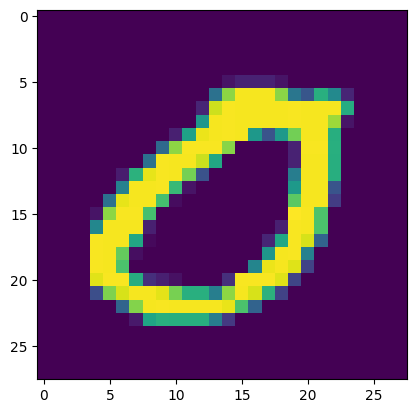

In [107]:
# Visualizing 5th image from the current batch

print(f'Label: {label[5]}')
plt.imshow(image[5].squeeze())
plt.show()